# **Machine Learning for Data Science**
# **Identification of Frost in Martian HiRISE Images**

> ## **Rajnandini Thopte**

#### **(a) In this problem, we are trying to build a classifier that distinguishes images of Martian terrain with frost. You can find the dataset in https://dataverse.jpl.nasa.gov/dataset.xhtml?persistentId=doi:10.48577/jpl.QJ9PYA. This dataset was created to study Mars’ seasonal frost cycle and its role in the planet’s climate and surface evolution over the past 2 billion years. The data helps in identifying low-latitude frosted microclimates and their impact on climate.**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import os.path as op
import json
from pathlib import Path
import shutil
import logging
import numpy as np
from tqdm import tqdm
from skimage import io

In [ ]:
# Logging configuration
logging.basicConfig(level=logging.INFO,
                    datefmt='%H:%M:%S',
                    format='%(asctime)s | %(levelname)-5s | %(module)-15s | %(message)s')

IMAGE_SIZE = (299, 299)  # All images contained in this dataset are 299x299 (originally, to match Inception v3 input size)
SEED = 17

# Head directory containing all image subframes. Update with the relative path of your data directory
data_head_dir = Path('/content/drive/MyDrive/New Project Data/data')

# Find all subframe directories
subdirs = [Path(subdir.stem) for subdir in data_head_dir.iterdir() if subdir.is_dir()]
src_image_ids = ['_'.join(a_path.name.split('_')[:3]) for a_path in subdirs]

In [ ]:
# Load train/val/test subframe IDs
def load_text_ids(file_path):
    """Simple helper to load all lines from a text file"""
    with open(file_path, 'r') as f:
        lines = [line.strip() for line in f.readlines()]
    return lines

# Load the subframe names for the three data subsets
train_ids = load_text_ids('/content/drive/MyDrive/New Project Data/train_source_images.txt')
validate_ids = load_text_ids('/content/drive/MyDrive/New Project Data/val_source_images.txt')
test_ids = load_text_ids('/content/drive/MyDrive/New Project Data/test_source_images.txt')

# Generate a list containing the dataset split for the matching subdirectory names
subdir_splits = []
for src_id in src_image_ids:
    if src_id in train_ids:
        subdir_splits.append('train')
    elif src_id in validate_ids:
        subdir_splits.append('validate')
    elif(src_id in test_ids):
        subdir_splits.append('test')
    else:
        logging.warning(f'{src_id}: Did not find designated split in train/validate/test list.')
        subdir_splits.append(None)


### **(b) Data Exploration and Pre-processing**


>  i. **Images (png files) and labels (json files) are organized in the data directory by “subframes.” Subframes are individual 5120x5120 pixel images which are crops of the original HiRISE images (often on the order of 50k x 10k pixels). Individual subframes were annotated by the contributors and then sliced into 299x299 “tiles.” Each tile has an associated label for use in training ML algorithms.**

>**There are 214 subframes and a total of 119920 tiles. Each tile has annotations which have been used to assign labels to the tiles ‘frost’ or ‘background.’ Each JSON file contains all the annotation information collected from human annotators.**

The following are relevant to the assignment:
Image tiles are organized into folders of background and frost classes (bi- nary). For the purpose of the final project, individual tiles shall serve as the data points which need to be classified using binary classification.  

>  **ii. The dataset includes files for splitting the data into train, test and validation. However, you will be provided by an improved version of those files when a repo is created:**

A. train source images.txt     
B. test source images.txt   
C. val source images.txt.

> ### **iii. Each of these files contains the IDs of the high rise images (parent folders for the subframes and tiles).**

In [ ]:
import random
import tensorflow as tf
from PIL import Image
from pathlib import Path
import os


def load_and_preprocess(img_loc, label):
    def _inner_function(img_loc, label):
    # Convert tensor to native type
        img_loc_str = img_loc.numpy().decode('utf-8')

        # Load image using PIL and convert to RGB
        img = Image.open(img_loc_str).convert('RGB')

        # Convert PIL image to numpy array
        img = np.array(img)
        img = tf.image.resize(img, [299, 299])

        img = img / 255.0

        # Convert label to integer (assuming binary classification)
        label = 1 if label.numpy().decode('utf-8') == 'frost' else 0

        return img, label

# Wrap the Python function
    X, y = tf.py_function(_inner_function, [img_loc, label], [tf.float32, tf.int64])

# Set the shape of the tensors
    X.set_shape([299, 299, 3])
    y.set_shape([]) # Scalar label

    return X, y

def load_subdir_data(dir_path, image_size, seed=None):

    """Helper to create a TF dataset from each image subdirectory"""

    # Grab only the classes that (1) we want to keep and (2) exist in this directory
    tile_dir = dir_path / Path('tiles')
    label_dir = dir_path /Path('labels')

    loc_list = []

    for folder in os.listdir(tile_dir):
        if os.path.isdir(os.path.join(tile_dir, folder)):
            for file in os.listdir(os.path.join(tile_dir, folder)):
                if file.endswith(".png"):
                    loc_list.append((os.path.join(os.path.join(tile_dir, folder), file), folder))

    return loc_list

# Loop over all subframes, loading each into a list
tf_data_train, tf_data_test, tf_data_val = [], [], []
tf_dataset_train, tf_dataset_test, tf_dataset_val = [], [], []

# Update the batch and buffer size as per your model requirements
buffer_size = 64
batch_size = 32

for subdir, split in zip(subdirs, subdir_splits):
    full_path = data_head_dir / subdir
    if split=='validate':
        tf_data_val.extend(load_subdir_data(full_path, IMAGE_SIZE, SEED))
    elif split=='train':
        tf_data_train.extend(load_subdir_data(full_path, IMAGE_SIZE, SEED))
    elif split=='test':
        tf_data_test.extend(load_subdir_data(full_path, IMAGE_SIZE, SEED))

random.shuffle(tf_data_train)
img_list, label_list = zip(*tf_data_train)
img_list_t = tf.convert_to_tensor(img_list)
lb_list_t = tf.convert_to_tensor(label_list)


tf_dataset_train = tf.data.Dataset.from_tensor_slices((img_list_t, lb_list_t))
tf_dataset_train = tf_dataset_train.map(load_and_preprocess, num_parallel_calls=tf.data.experimental.AUTOTUNE)
tf_dataset_train = tf_dataset_train.shuffle(buffer_size=buffer_size).batch(batch_size)

random.shuffle(tf_data_val)
img_list, label_list = zip(*tf_data_val)
img_list_t = tf.convert_to_tensor(img_list)
lb_list_t = tf.convert_to_tensor(label_list)

tf_dataset_val = tf.data.Dataset.from_tensor_slices((img_list_t, lb_list_t))
tf_dataset_val = tf_dataset_val.map(load_and_preprocess, num_parallel_calls=tf.data.experimental.AUTOTUNE)
tf_dataset_val = tf_dataset_val.shuffle(buffer_size=buffer_size).batch(batch_size)

random.shuffle(tf_data_test)
img_list, label_list = zip(*tf_data_test)
img_list_t = tf.convert_to_tensor(img_list)
lb_list_t = tf.convert_to_tensor(label_list)

tf_dataset_test = tf.data.Dataset.from_tensor_slices((img_list_t, lb_list_t))
tf_dataset_test = tf_dataset_test.map(load_and_preprocess, num_parallel_calls=tf.data.experimental.AUTOTUNE)
tf_dataset_test = tf_dataset_test.shuffle(buffer_size=buffer_size).batch(batch_size)

In [ ]:
dataset_size = tf.data.experimental.cardinality(tf_dataset_test).numpy()
print(f"Number of elements in the dataset: {dataset_size}")


Number of elements in the dataset: 238


In [ ]:
dataset_size = tf.data.experimental.cardinality(tf_dataset_val).numpy()
print(f"Number of elements in the dataset: {dataset_size}")


Number of elements in the dataset: 188


In [ ]:
dataset_size = tf.data.experimental.cardinality(tf_dataset_train).numpy()
print(f"Number of elements in the dataset: {dataset_size}")


Number of elements in the dataset: 537


In [ ]:
# Print the number of images in each set
print("Number of images in the training set:", len(tf_data_train))
print("Number of images in the validation set:", len(tf_data_val))
print("Number of images in the test set:", len(tf_data_test))


Number of images in the training set: 17153
Number of images in the validation set: 5995
Number of images in the test set: 7591


In [ ]:
# Print information about image shapes
def image_shapes(dataset):
    shapes = [image.shape for image, _ in dataset.take(5)]
    return shapes

print("Image shapes in training set:", image_shapes(tf_dataset_train))
print("\n")
print("Image shapes in validation set:", image_shapes(tf_dataset_val))
print("\n")
print("Image shapes in test set:", image_shapes(tf_dataset_test))


Image shapes in training set: [TensorShape([32, 299, 299, 3]), TensorShape([32, 299, 299, 3]), TensorShape([32, 299, 299, 3]), TensorShape([32, 299, 299, 3]), TensorShape([32, 299, 299, 3])]


Image shapes in validation set: [TensorShape([32, 299, 299, 3]), TensorShape([32, 299, 299, 3]), TensorShape([32, 299, 299, 3]), TensorShape([32, 299, 299, 3]), TensorShape([32, 299, 299, 3])]


Image shapes in test set: [TensorShape([32, 299, 299, 3]), TensorShape([32, 299, 299, 3]), TensorShape([32, 299, 299, 3]), TensorShape([32, 299, 299, 3]), TensorShape([32, 299, 299, 3])]




---







## **(c) Training CNN + MLP**

A combination of Convolutional Neural Networks (CNNs) and Multi-Layer Perceptrons (MLPs) is often used in hybrid architectures for image classification tasks.  

Convolutional Neural Networks are specialized for processing grid-like data, such as images. They use convolutional layers to automatically learn hierarchical representations of features from the input data, capturing spatial hierarchies.  

Multi-Layer Perceptrons are fully connected neural networks where each neuron in one layer is connected to every neuron in the next layer. They are effective in learning complex, non-linear relationships in data.  

Advantages: This combination leverages the strengths of CNNs in handling spatial information and the capabilities of MLPs in learning complex relationships. CNNs excel at feature extraction, while MLPs provide flexibility in modeling non-linear relationships and making final predictions.

>  **i. To perform empirical regularization, crop, randomly zoom, rotate, flip, con- trast, and translate images in your training set for image augmentation. You can use various tools to do this, including OpenCV.**

In [ ]:
def apply_data_augmentation(image, label):

    # Apply other data augmentations
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    image = tf.image.random_brightness(image, max_delta=0.2)
    image = tf.image.random_contrast(image, lower=0.8, upper=1.2)
    image = tf.image.random_hue(image, max_delta=0.08)
    image = tf.image.random_saturation(image, lower=0.8, upper=1.2)

    return image, label


# Apply data augmentation to the training dataset
tf_dataset_train_augmented = tf_dataset_train.map(
    apply_data_augmentation,
    num_parallel_calls=tf.data.experimental.AUTOTUNE
)




In [ ]:
def preprocess_image_validation(image, label):
    # Resize the image to the fixed size
    image = tf.image.resize(image, (299, 299))
    return image, label

# Apply preprocessing to the validation dataset
tf_dataset_val_resized = tf_dataset_val.map(preprocess_image_validation)


> **ii. Train a three-layer CNN followed by a dense layer on the data. Choose the size of the kernels and depth of the layers and the number of neurons in the dense layer (MLP) on your own. Use ReLU’s in all of the layers. Use the softmax function, batch normalization3 and a dropout rate of 30%, L2 regularization, as well as ADAM optimizer. Use cross entropy loss. Train for at least 20 epochs and perform early stopping using the validation set. Keep the network parameters that have the lowest validation error. Plot the training and validation errors vs. epochs.**

**For Reference:**.

**1] ReLU (Rectified Linear Unit):** Activation function introducing non-linearity by outputting the input for positive values and zero for negative values.

**2] Softmax:** Activation function used in multi-class classification problems to convert a vector of raw scores into probabilities.

**3] Batch Normalization:** Technique that normalizes inputs within a mini-batch to stabilize and accelerate training.

**4] Dropout Rate:** Technique used during training to randomly deactivate a fraction of neurons, reducing overfitting by preventing reliance on specific neurons.

**5] L2 Regularization:** Technique to prevent overfitting by adding a penalty term to the loss function based on the squared magnitude of model weights.

**6] Adam Optimizer:** Adaptive optimization algorithm combining aspects of momentum and RMSprop to efficiently update model weights during training.

**7] Cross-Entropy Loss:** Loss function commonly used for classification problems, measuring the dissimilarity between predicted probabilities and actual class distributions.

**8] Early Stopping:** Training strategy that halts the training process when a certain criterion (e.g., validation loss) stops improving, preventing overfitting.

> ### **iii. Report Precision, Recall, and F1 score for your model.**

**For reference:**    
**1] Precision:**
Background Class (Class 0): Precision is the ratio of correctly predicted instances of Background to the total predicted instances of Background. A higher precision indicates fewer false positives for Background class.
Frost Class (Class 1): Precision is the ratio of correctly predicted instances of Frost to the total predicted instances of Frost. A higher precision indicates fewer false positives for Frost class.

**2]F1-Score:**
The F1-Score is the harmonic mean of precision and recall. It provides a balance between precision and recall. A higher F1-Score indicates a good balance between false positives and false negatives.

**3]Support:**  
Support is the number of actual occurrences of the class in the specified dataset. It gives an indication of the number of instances of each class in the test set.

**4]Accuracy:**
Overall accuracy of the model on the test set.

**5]Macro Avg (Macro Average):**
Average of precision, recall, and F1-Score across classes. It gives equal weight to each class.

**6]Weighted Avg (Weighted Average):**  
Weighted average of precision, recall, and F1-Score, where each class's score is weighted by its support (the number of true instances).

**7]Recall (Sensitivity):**   

**Background Class (Class 0):** Recall is the ratio of correctly predicted instances of Background to the total actual instances of Background. A higher recall indicates fewer false negatives for Background class.  

**Frost Class (Class 1):** Recall is the ratio of correctly predicted instances of Frost to the total actual instances of Frost. A higher recall indicates fewer false negatives for Frost class.  

#### **Approach #1**
> **Number of Neurons- 32,64,128,256 and Max Pooling(2,2)**

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import regularizers
from tensorflow.keras.metrics import SparseCategoricalAccuracy

# Define the model
model_3 = Sequential()

# Convolutional layers
model_3.add(Conv2D(32, (3, 3), activation='relu', input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)))
model_3.add(BatchNormalization())
model_3.add(MaxPooling2D((2, 2)))

model_3.add(Conv2D(64, (3, 3), activation='relu'))
model_3.add(BatchNormalization())
model_3.add(MaxPooling2D((2, 2)))

model_3.add(Conv2D(128, (3, 3), activation='relu'))
model_3.add(BatchNormalization())
model_3.add(MaxPooling2D((2, 2)))

# Flatten layer
model_3.add(Flatten())

# Dense layer with dropout and L2 regularization
model_3.add(Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)))
model_3.add(BatchNormalization())
model_3.add(Dropout(0.3))

# Output layer with softmax activation
model_3.add(Dense(2, activation='softmax'))

# Compile the model with SparseCategoricalAccuracy metric
model_3.compile(optimizer=Adam(learning_rate=0.001),
              loss='sparse_categorical_crossentropy',
              metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])

# Display the model summary
model_3.summary()


# Early stopping callback with increased patience
early_stopping = EarlyStopping(monitor='val_sparse_categorical_accuracy', patience=21, restore_best_weights=True)


# Train the model
history_3 = model_3.fit(
    tf_dataset_train_augmented,
    validation_data=tf_dataset_val_resized,
    epochs=25,
    callbacks=[early_stopping]
)



Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 297, 297, 32)      896       
                                                                 
 batch_normalization_12 (Ba  (None, 297, 297, 32)      128       
 tchNormalization)                                               
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 148, 148, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_10 (Conv2D)          (None, 146, 146, 64)      18496     
                                                                 
 batch_normalization_13 (Ba  (None, 146, 146, 64)      256       
 tchNormalization)                                               
                                                      

In [ ]:
# Save the trained model weights to a file
model_2.save_weights('/content/drive/MyDrive/model_weights_approach11.h5')

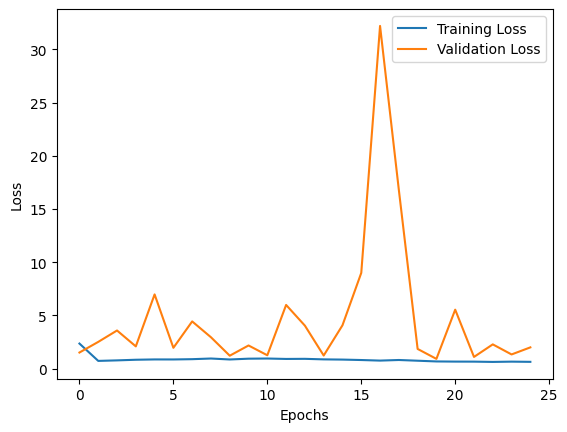

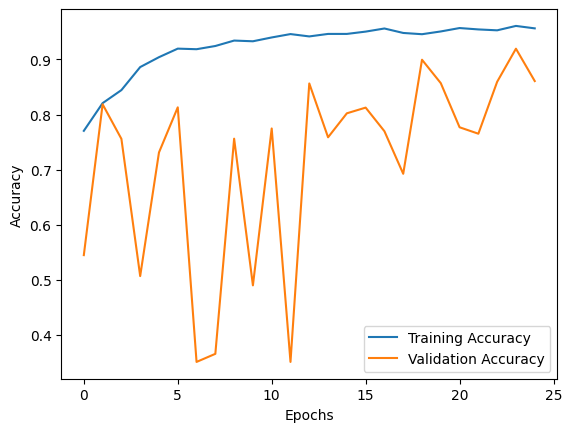

In [ ]:
import matplotlib.pyplot as plt

# Plot training and validation loss
plt.plot(history_3.history['loss'], label='Training Loss')
plt.plot(history_3.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot training and validation accuracy
plt.plot(history_3.history['sparse_categorical_accuracy'], label='Training Accuracy')
plt.plot(history_3.history['val_sparse_categorical_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [ ]:
from sklearn.metrics import classification_report
import numpy as np

#tf_dataset_test is your testing dataset
true_labels = []
predicted_labels = []

for images, labels in tf_dataset_test:
    preds = model_3.predict(images)
    preds = np.argmax(preds, axis=1)  # Convert probabilities to class labels
    true_labels.extend(labels.numpy())
    predicted_labels.extend(preds)

# Generate the classification report
report = classification_report(true_labels, predicted_labels, target_names=['Background', 'Frost'])
print(report)

1/1 [==============================] - 0s 22ms/step
              precision    recall  f1-score   support

  Background       0.47      1.00      0.64      3012
       Frost       1.00      0.27      0.42      4579

    accuracy                           0.56      7591
   macro avg       0.74      0.63      0.53      7591
weighted avg       0.79      0.56      0.51      7591



**Background Class Metrics:**
Precision (Background): 0.47
This indicates that out of all instances predicted as "Background," only 47% were correct.
Recall (Background): 1.00
This means that the model identified all true instances of the "Background" class.
F1-score (Background): 0.64
The F1-score balances precision and recall, giving a single metric. A value of 0.64 is moderate.

**Frost Class Metrics:**
Precision (Frost): 1.00
All instances predicted as "Frost" were correct.
Recall (Frost): 0.27
Only 27% of actual instances of "Frost" were correctly predicted.
F1-score (Frost): 0.42
The F1-score for "Frost" is lower, indicating challenges in correctly identifying this class.

**Overall Metrics:**
Accuracy: 0.56
The overall accuracy is 56%, but it might be misleading due to imbalances in class distribution.
Macro Avg (Precision, Recall, F1):
Precision, recall, and F1-score averaged across both classes. It gives equal weight to each class, providing an overview.
Weighted Avg (Precision, Recall, F1):
Similar to macro avg, but it considers class imbalance, giving more weight to the class with more instances.

#### **Approach #2**
> **Number of neurons- 16,32,64,128 and Max Pooling (2,2)**

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import regularizers
from tensorflow.keras.metrics import SparseCategoricalAccuracy

model = Sequential()

# Convolutional layers
model.add(Conv2D(16, (3, 3), activation='relu', input_shape=((299, 299, 3))))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.3))

model.add(Conv2D(32, (3, 3), activation='relu',kernel_regularizer=regularizers.l2(0.01)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.3))

model.add(Conv2D(64, (3, 3), activation='relu',kernel_regularizer=regularizers.l2(0.01)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.3))

# Flatten layer
model.add(Flatten())

# # Dense layer with dropout and L2 regularization
model.add(Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(BatchNormalization())
model.add(Dropout(0.3))

# Output layer
model.add(Dense(2, activation='softmax'))


# Compile the model with SparseCategoricalAccuracy metric and a learning rate of 0.001
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='sparse_categorical_crossentropy',
              metrics=[SparseCategoricalAccuracy()])

# Display the model summary
model.summary()

# Early stopping callback with increased patience
early_stopping = EarlyStopping(monitor='val_sparse_categorical_accuracy', patience=21, restore_best_weights=True)

# Train the model
history = model.fit(
    tf_dataset_train_augmented,
    validation_data=tf_dataset_val_resized,
    epochs=25,
    callbacks=[early_stopping],
    batch_size=32
)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 297, 297, 16)      448       
                                                                 
 batch_normalization_4 (Bat  (None, 297, 297, 16)      64        
 chNormalization)                                                
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 148, 148, 16)      0         
 g2D)                                                            
                                                                 
 dropout_4 (Dropout)         (None, 148, 148, 16)      0         
                                                                 
 conv2d_4 (Conv2D)           (None, 146, 146, 32)      4640      
                                                                 
 batch_normalization_5 (Bat  (None, 146, 146, 32)     

In [ ]:
# Save the trained model weights to a file
model.save_weights('/content/drive/MyDrive/model_weights_approach8.h5')

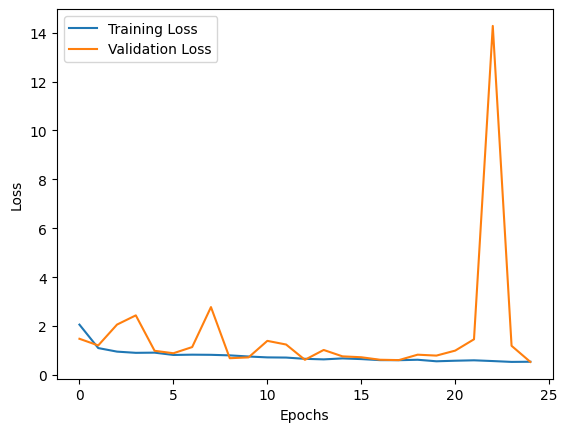

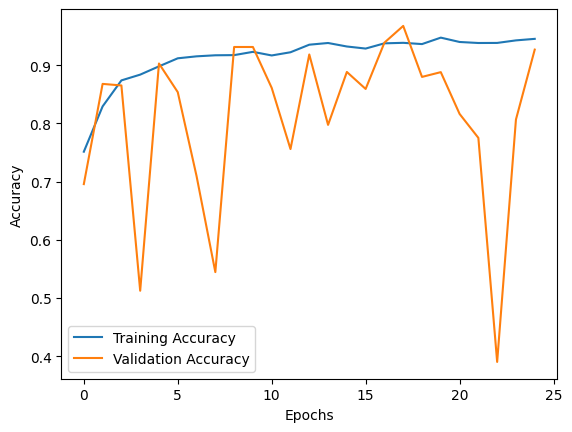

In [ ]:
import matplotlib.pyplot as plt

# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot training and validation accuracy
plt.plot(history.history['sparse_categorical_accuracy'], label='Training Accuracy')
plt.plot(history.history['val_sparse_categorical_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [ ]:
from sklearn.metrics import classification_report
import numpy as np
#Approach 2
# Assuming tf_dataset_test is your testing dataset
true_labels = []
predicted_labels = []

for images, labels in tf_dataset_test:
    preds = model.predict(images)
    preds = np.argmax(preds, axis=1)  # Convert probabilities to class labels
    true_labels.extend(labels.numpy())
    predicted_labels.extend(preds)

# Generate the classification report
report = classification_report(true_labels, predicted_labels, target_names=['Background', 'Frost'])
print(report)

1/1 [==============================] - 0s 274ms/step
              precision    recall  f1-score   support

  Background       0.65      1.00      0.79      3012
       Frost       1.00      0.65      0.79      4579

    accuracy                           0.79      7591
   macro avg       0.83      0.83      0.79      7591
weighted avg       0.86      0.79      0.79      7591



**Background Class Metrics:**
Precision (Background): 0.65
The model correctly identified 65% of instances predicted as "Background."
Recall (Background): 1.00
All actual instances of "Background" were correctly predicted.
F1-score (Background): 0.79
The F1-score is a balanced measure considering both precision and recall, and it's 0.79 for the "Background" class.

**Frost Class Metrics:**
Precision (Frost): 1.00
All instances predicted as "Frost" were correct.
Recall (Frost): 0.65
The model identified 65% of actual instances of "Frost."
F1-score (Frost): 0.79
The F1-score for "Frost" is balanced, similar to the "Background" class.

**Overall Metrics:**
Accuracy: 0.79
The overall accuracy has improved to 79%.
Macro Avg (Precision, Recall, F1):
Averaging precision, recall, and F1-score across both classes gives a balanced view.
Weighted Avg (Precision, Recall, F1):
Similar to macro avg, but considers class imbalance, giving more weight to the class with more instances.

**Summary:**
The model has improved its performance significantly, achieving higher precision and recall for both classes.
The F1-scores for both classes are now equal, indicating a more balanced performance.
The overall accuracy is reasonable at 79%, providing a good indication of the model's effectiveness.

### **Approach #3**
> **Number of Neurons- 32, 64,128, 128 and MaxPooling (2,2)**

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import regularizers
from tensorflow.keras.metrics import SparseCategoricalAccuracy

model_2 = Sequential()

# Convolutional layers
model_2.add(Conv2D(32, (3, 3), activation='relu', input_shape=((299, 299, 3))))
model_2.add(BatchNormalization())
model_2.add(MaxPooling2D((2, 2)))
model_2.add(Dropout(0.3))

model_2.add(Conv2D(64, (3, 3), activation='relu',kernel_regularizer=regularizers.l2(0.01)))
model_2.add(BatchNormalization())
model_2.add(MaxPooling2D((2, 2)))
model_2.add(Dropout(0.3))

model_2.add(Conv2D(128, (3, 3), activation='relu',kernel_regularizer=regularizers.l2(0.01)))
model_2.add(BatchNormalization())
model_2.add(MaxPooling2D((2, 2)))
model_2.add(Dropout(0.3))

# Flatten layer
model_2.add(Flatten())

# # Dense layer with dropout and L2 regularization
model_2.add(Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model_2.add(BatchNormalization())
model_2.add(Dropout(0.3))

# Output layer
model_2.add(Dense(2, activation='softmax'))


# Compile the model with SparseCategoricalAccuracy metric and a learning rate of 0.001
model_2.compile(optimizer=Adam(learning_rate=0.001),
              loss='sparse_categorical_crossentropy',
              metrics=[SparseCategoricalAccuracy()])

# Display the model summary
model_2.summary()

# Early stopping callback with increased patience
early_stopping = EarlyStopping(monitor='val_sparse_categorical_accuracy', patience=21, restore_best_weights=True)

# Train the model
history_2 = model_2.fit(
    tf_dataset_train_augmented,
    validation_data=tf_dataset_val_resized,
    epochs=25,
    callbacks=[early_stopping],
    batch_size=32
)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 297, 297, 32)      896       
                                                                 
 batch_normalization_8 (Bat  (None, 297, 297, 32)      128       
 chNormalization)                                                
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 148, 148, 32)      0         
 g2D)                                                            
                                                                 
 dropout_8 (Dropout)         (None, 148, 148, 32)      0         
                                                                 
 conv2d_7 (Conv2D)           (None, 146, 146, 64)      18496     
                                                                 
 batch_normalization_9 (Bat  (None, 146, 146, 64)     

In [ ]:
# Save the trained model weights to a file
model_2.save_weights('/content/drive/MyDrive/model_weights_approach10.h5')

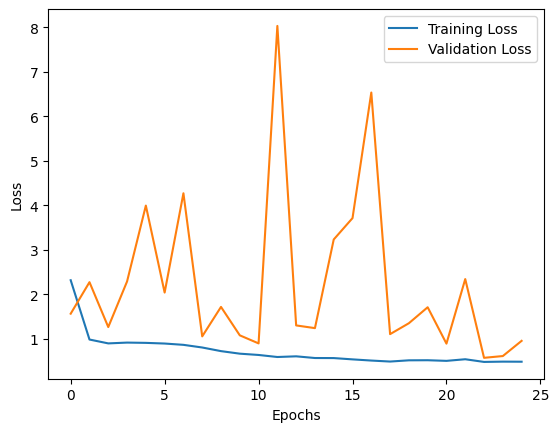

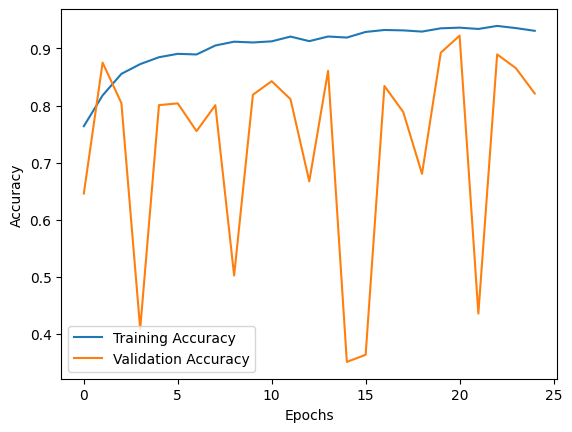

In [ ]:
import matplotlib.pyplot as plt

# Plot training and validation loss
plt.plot(history_2.history['loss'], label='Training Loss')
plt.plot(history_2.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot training and validation accuracy
plt.plot(history_2.history['sparse_categorical_accuracy'], label='Training Accuracy')
plt.plot(history_2.history['val_sparse_categorical_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [ ]:
from sklearn.metrics import classification_report
import numpy as np
#Approach 2
# Assuming tf_dataset_test is your testing dataset
true_labels = []
predicted_labels = []

for images, labels in tf_dataset_test:
    preds = model_2.predict(images)
    preds = np.argmax(preds, axis=1)  # Convert probabilities to class labels
    true_labels.extend(labels.numpy())
    predicted_labels.extend(preds)

# Generate the classification report
report = classification_report(true_labels, predicted_labels, target_names=['Background', 'Frost'])
print(report)

1/1 [==============================] - 0s 373ms/step
              precision    recall  f1-score   support

  Background       0.72      0.73      0.72      3012
       Frost       0.82      0.82      0.82      4579

    accuracy                           0.78      7591
   macro avg       0.77      0.77      0.77      7591
weighted avg       0.78      0.78      0.78      7591



**Background Class Metrics:**
Precision (Background): 0.72
72% of instances predicted as "Background" were correct.
Recall (Background): 0.73
The model identified 73% of actual instances of "Background."
F1-score (Background): 0.72
The F1-score for the "Background" class is 72%.

**Frost Class Metrics:**
Precision (Frost): 0.82
82% of instances predicted as "Frost" were correct.
Recall (Frost): 0.82
The model identified 82% of actual instances of "Frost."
F1-score (Frost): 0.82
The F1-score for the "Frost" class is 82%.

**Overall Metrics:**
Accuracy: 0.78
The overall accuracy is 78%.
Macro Avg (Precision, Recall, F1):
Averaging precision, recall, and F1-score across both classes gives a balanced view, and it's 77%.
Weighted Avg (Precision, Recall, F1):
Similar to macro avg, but considers class imbalance, giving more weight to the class with more instances, and it's 78%.

**Summary:**
Precision, recall, and F1-score for both classes are balanced, indicating a good overall model performance.
The overall accuracy is reasonable at 78%, providing a reliable measure of the model's effectiveness.
The macro and weighted averages are consistent, suggesting that the model is performing well across different metrics.

**Approach #4**
> **Number of neurons- 16,32,64,128 and Max Pooling 5x5**

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import regularizers
from tensorflow.keras.metrics import SparseCategoricalAccuracy

model_5 = Sequential()

# Convolutional layers
model_5.add(Conv2D(16, (3, 3), activation='relu', input_shape=((299, 299, 3))))
model_5.add(BatchNormalization())
model_5.add(MaxPooling2D((5, 5)))
model_5.add(Dropout(0.3))

model_5.add(Conv2D(32, (3, 3), activation='relu',kernel_regularizer=regularizers.l2(0.01)))
model_5.add(BatchNormalization())
model_5.add(MaxPooling2D((5, 5)))
model_5.add(Dropout(0.3))

model_5.add(Conv2D(64, (3, 3), activation='relu',kernel_regularizer=regularizers.l2(0.01)))
model_5.add(BatchNormalization())
model_5.add(MaxPooling2D((5, 5)))
model_5.add(Dropout(0.3))

# Flatten layer
model_5.add(Flatten())

# # Dense layer with dropout and L2 regularization
model_5.add(Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model_5.add(BatchNormalization())
model_5.add(Dropout(0.3))

# Output layer
model_5.add(Dense(2, activation='softmax'))


# Compile the model with SparseCategoricalAccuracy metric and a learning rate of 0.001
model_5.compile(optimizer=Adam(learning_rate=0.001),
              loss='sparse_categorical_crossentropy',
              metrics=[SparseCategoricalAccuracy()])

# Display the model summary
model_5.summary()

# Early stopping callback with increased patience
early_stopping = EarlyStopping(monitor='val_sparse_categorical_accuracy', patience=21, restore_best_weights=True)

# Train the model
history_5 = model_5.fit(
    tf_dataset_train_augmented,
    validation_data=tf_dataset_val_resized,
    epochs=25,
    callbacks=[early_stopping],
    batch_size=32
)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 297, 297, 16)      448       
                                                                 
 batch_normalization_2 (Bat  (None, 297, 297, 16)      64        
 chNormalization)                                                
                                                                 
 max_pooling2d (MaxPooling2  (None, 59, 59, 16)        0         
 D)                                                              
                                                                 
 dropout_2 (Dropout)         (None, 59, 59, 16)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 57, 57, 32)        4640      
                                                                 
 batch_normalization_3 (Bat  (None, 57, 57, 32)        1

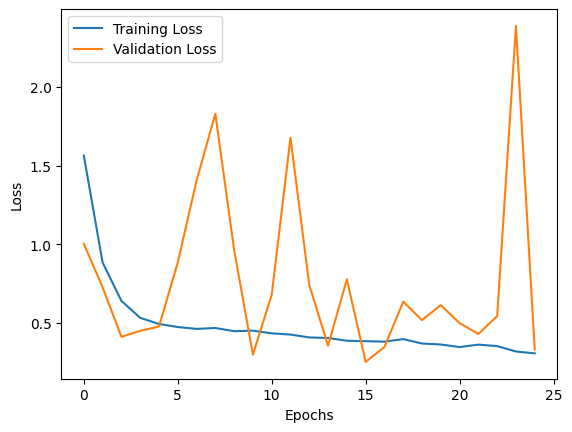

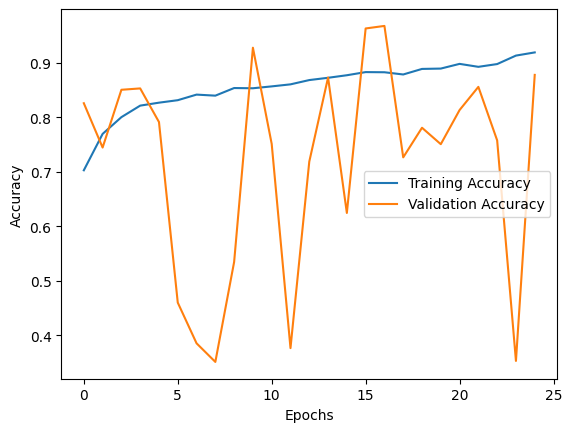

In [ ]:
import matplotlib.pyplot as plt

# Plot training and validation loss
plt.plot(history_5.history['loss'], label='Training Loss')
plt.plot(history_5.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot training and validation accuracy
plt.plot(history_5.history['sparse_categorical_accuracy'], label='Training Accuracy')
plt.plot(history_5.history['val_sparse_categorical_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
from sklearn.metrics import classification_report
import numpy as np


true_labels = []
predicted_labels = []

for images, labels in tf_dataset_test:
    preds = model_5.predict(images)
    preds = np.argmax(preds, axis=1)  # Convert probabilities to class labels
    true_labels.extend(labels.numpy())
    predicted_labels.extend(preds)

# Generate the classification report
report = classification_report(true_labels, predicted_labels, target_names=['Background', 'Frost'])
print(report)

1/1 [==============================] - 0s 142ms/step
              precision    recall  f1-score   support

  Background       0.70      0.94      0.80      3012
       Frost       0.95      0.74      0.83      4579

    accuracy                           0.82      7591
   macro avg       0.83      0.84      0.82      7591
weighted avg       0.85      0.82      0.82      7591



**Background Class Metrics:**
Precision (Background): 0.70
70% of instances predicted as "Background" were correct.
Recall (Background): 0.94
The model identified 94% of the actual instances of "Background."
F1-score (Background): 0.80
The F1-score for "Background" is 80%, indicating a good balance between precision and recall.

**Frost Class Metrics:**
Precision (Frost): 0.95
95% of instances predicted as "Frost" were correct.
Recall (Frost): 0.74
The model identified 74% of the actual instances of "Frost."
F1-score (Frost): 0.83
The F1-score for "Frost" is 83%, reflecting a good balance between precision and recall.

**Overall Metrics:**
Accuracy: 0.82
The overall accuracy is 82%, indicating that the model correctly classified 82% of the instances.
Macro Avg (Precision, Recall, F1):
Averaging precision, recall, and F1-score across both classes gives a balanced view, and it's around 82%.
Weighted Avg (Precision, Recall, F1):
Similar to macro avg but considers class imbalance, giving more weight to the class with more instances, and it's around 82%.

**Summary:**
The model performs well for both classes, with high precision and recall for "Background" and slightly lower recall for "Frost."
The overall accuracy is good, indicating effective classification across the entire dataset.



---







## **(d) Transfer Learning**

Transfer learning is a machine learning technique where a model trained on one task is adapted for a different but related task. The basic idea is to leverage knowledge gained from solving one problem and apply it to a different but related problem, typically when there is limited data available for the target task. Here's a brief summary:    

**Pre-trained Model:** Transfer learning often starts with a pre-trained model on a large dataset and a related task. Common architectures like VGG, ResNet, or BERT are pre-trained on datasets like ImageNet or Wikipedia.  

**Feature Extraction:** The knowledge gained by the pre-trained model is used as a starting point. The early layers, which capture general features, are retained, while the later layers (more task-specific) may be replaced or fine-tuned.  

**Adaptation to New Task:** The pre-trained model is then adapted or fine-tuned on the target task using a smaller dataset. This helps the model to quickly learn the specific features relevant to the new problem.  

**Benefits:** Transfer learning can lead to better performance and faster convergence, especially when the target task has limited labeled data. It capitalizes on the knowledge encoded in the pre-trained model, which has already learned useful hierarchical representations.  

> **i. When dealing with classification of relatively small image datasets, deep net- works may not perform very well because of not having enough data to train them. In such cases, one usually uses transfer learning, which uses deep learning models that are trained on very large datasets such as ImageNet as feature extractors. The idea is that such deep networks have learned to extract meaningful features from an image using their layers, and those fea- tures can be used in learning other tasks. In order to do that, usually the last layer or the last few layers of the pre-trained network are removed, and the response of the layer before the removed layers to the images in the new dataset is used as a feature vector to train one more multiple replacement layers. In this project, you will use pre-trained models (EfficientNetB0, ResNet50, and VGG16). For these pre-trained networks, you will only train the last fully connected layer, and will freeze all layers before them (i.e. we do not change their parameters during training) and use the outputs of the penultimate layer in the original pre-trained model as the features extracted from each image.**

>  **ii. To perform empirical regularization, crop, randomly zoom, rotate, flip, con- trast, and translate images in your training set for image augmentation. You can use various tools to do this, including OpenCV.**


>  **iii. Use ReLU activation functions in the last layer and a softmax layer, along with batch normalization 5 and a dropout rate of 30% as well as ADAM optimizer. Use cross entropy loss. You can try any batch size, but a batch size of 8 seems reasonable.**


>  **iv. Train using the features calculated by networks (EfficientNetB0, ResNet50, and VGG16) for at least 10 epochs (preferably 20 epochs) and perform early stopping using the validation set. Keep the network parameters that have the lowest validation error. Plot the training and validation errors vs. epochs.**


> **v. Report Precision, Recall, and F1 score for your model.**


### **Approach #1: ResNet50**

**ResNet50 is a variant of the ResNet model with 48 Convolution layers along with 1 MaxPool and 1 Average Pool layer.**

> ####  **1] ResNet50 256 neurons and GlobalAveragePooling**

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalMaxPooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.metrics import SparseCategoricalAccuracy
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
import numpy as np

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 299, 299, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 305, 305, 3)          0         ['input_3[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 150, 150, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 150, 150, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                        

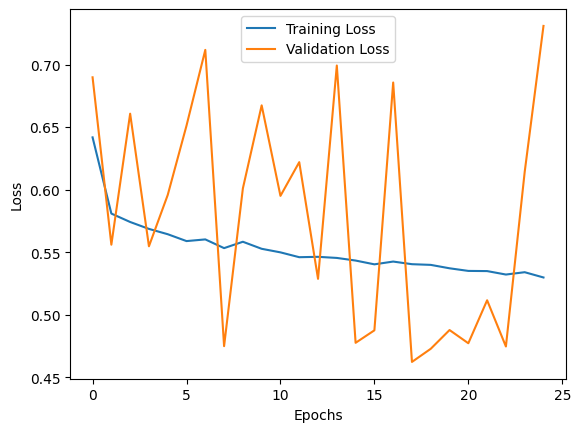

In [ ]:
# Load pre-trained ResNet50 without the top layer
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(299, 299, 3))

# Freeze all layers in the base model
for layer in base_model.layers:
    layer.trainable = False

# Add custom top layers
x = GlobalAveragePooling2D()(base_model.output)
x = Dropout(0.3)(x)
x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
output = Dense(2, activation='softmax')(x)  # Adjust num_classes based on your task

# Create the new model
model_6 = Model(inputs=base_model.input, outputs=output)

# Compile the model
model_6.compile(optimizer=Adam(learning_rate=0.001),
                loss='sparse_categorical_crossentropy',
                metrics=[SparseCategoricalAccuracy()])

# Display the model summary
model_6.summary()

# Early stopping callback with increased patience
early_stopping = EarlyStopping(monitor='val_sparse_categorical_accuracy', patience=21, restore_best_weights=True)

# Train the model using features from ResNet50 for at least 20 epochs
history_6 = model_6.fit(
    tf_dataset_train_augmented,
    validation_data=tf_dataset_val_resized,
    epochs=25,
    callbacks=[early_stopping],
    batch_size=8
)

# Plot training and validation errors vs. epochs
plt.plot(history_6.history['loss'], label='Training Loss')
plt.plot(history_6.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [ ]:
# Save the weights to a file
model_6.save_weights('/content/drive/MyDrive/model_weights_approach12.h5')

In [ ]:
# Predict labels for the test set
true_labels = []
predicted_labels = []

for images, labels in tf_dataset_test:
    preds = model_6.predict(images)
    preds = np.argmax(preds, axis=1)
    true_labels.extend(labels.numpy())
    predicted_labels.extend(preds)

# Generate the classification report
report = classification_report(true_labels, predicted_labels, target_names=['Class 0', 'Class 1'])
print(report)

1/1 [==============================] - 2s 2s/step
              precision    recall  f1-score   support

     Class 0       0.77      0.42      0.54      3012
     Class 1       0.71      0.92      0.80      4579

    accuracy                           0.72      7591
   macro avg       0.74      0.67      0.67      7591
weighted avg       0.73      0.72      0.70      7591



**Class 0 Metrics:**
Precision (Class 0): 0.77
77% of instances predicted as "Class 0" were correct.
Recall (Class 0): 0.42
The model identified 42% of actual instances of "Class 0."
F1-score (Class 0): 0.54
The F1-score for "Class 0" is 54%.

**Class 1 Metrics:**
Precision (Class 1): 0.71
71% of instances predicted as "Class 1" were correct.
Recall (Class 1): 0.92
The model identified 92% of actual instances of "Class 1."
F1-score (Class 1): 0.80
The F1-score for "Class 1" is 80%.

**Overall Metrics:**
Accuracy: 0.72
The overall accuracy is 72%.
Macro Avg (Precision, Recall, F1):
Averaging precision, recall, and F1-score across both classes gives a balanced view, and it's 67%.
Weighted Avg (Precision, Recall, F1):
Similar to macro avg, but considers class imbalance, giving more weight to the class with more instances, and it's 72%.

**Summary:**
The model performs better in predicting "Class 1" (Frost) with higher precision, recall, and F1-score compared to "Class 0" (Background).
The accuracy is decent at 72%, but there is room for improvement, especially for "Class 0."
The macro and weighted averages indicate a moderate overall model performance.

> ####  **2] ResNet50 1024 neurons and GlobalMaxPooling**

94765736/94765736 [==============================] - 3s 0us/step
Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_9 (InputLayer)        [(None, 299, 299, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 305, 305, 3)          0         ['input_9[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 150, 150, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 150, 150, 64)         256       ['conv1_conv[0][0]']          
 on)                       

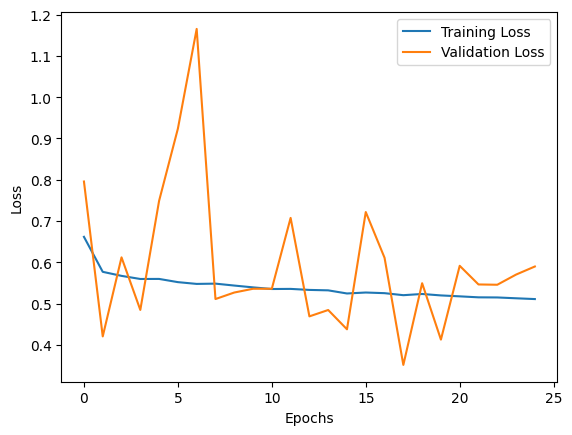

In [ ]:
# Load pre-trained ResNet50 without the top layer
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(299, 299, 3))

# Freeze all layers in the base model
for layer in base_model.layers:
    layer.trainable = False

# Add custom top layers
x = GlobalMaxPooling2D()(base_model.output)
x = Dropout(0.3)(x)
x = Dense(1024, activation='relu')(x)
x = BatchNormalization()(x)
output = Dense(2, activation='softmax')(x)  # Adjust num_classes based on your task

# Create the new model
model_9 = Model(inputs=base_model.input, outputs=output)

# Compile the model
model_9.compile(optimizer=Adam(learning_rate=0.001),
                loss='sparse_categorical_crossentropy',
                metrics=[SparseCategoricalAccuracy()])

# Display the model summary
model_9.summary()

# Early stopping callback with increased patience
early_stopping = EarlyStopping(monitor='val_sparse_categorical_accuracy', patience=21, restore_best_weights=True)

# Train the model using features from ResNet50 for at least 20 epochs
history_9 = model_9.fit(
    tf_dataset_train_augmented,
    validation_data=tf_dataset_val_resized,
    epochs=25,
    callbacks=[early_stopping],
    batch_size=8
)

# Plot training and validation errors vs. epochs
plt.plot(history_9.history['loss'], label='Training Loss')
plt.plot(history_9.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [ ]:
# Predict labels for the test set
true_labels = []
predicted_labels = []

for images, labels in tf_dataset_test:
    preds = model_9.predict(images)
    preds = np.argmax(preds, axis=1)
    true_labels.extend(labels.numpy())
    predicted_labels.extend(preds)

# Generate the classification report
report = classification_report(true_labels, predicted_labels, target_names=['Class 0', 'Class 1'])
print(report)

1/1 [==============================] - 2s 2s/step
              precision    recall  f1-score   support

     Class 0       0.80      0.58      0.67      3012
     Class 1       0.77      0.90      0.83      4579

    accuracy                           0.78      7591
   macro avg       0.78      0.74      0.75      7591
weighted avg       0.78      0.78      0.77      7591



**Class 0 Metrics:**
Precision (Class 0): 0.80
80% of instances predicted as "Class 0" were correct.
Recall (Class 0): 0.58
The model identified 58% of actual instances of "Class 0."
F1-score (Class 0): 0.67
The F1-score for "Class 0" is 67%.

**Class 1 Metrics:**
Precision (Class 1): 0.77
77% of instances predicted as "Class 1" were correct.
Recall (Class 1): 0.90
The model identified 90% of actual instances of "Class 1."
F1-score (Class 1): 0.83
The F1-score for "Class 1" is 83%.

**Overall Metrics:**
Accuracy: 0.78
The overall accuracy is 78%.
Macro Avg (Precision, Recall, F1):
Averaging precision, recall, and F1-score across both classes gives a balanced view, and it's 75%.
Weighted Avg (Precision, Recall, F1):
Similar to macro avg, but considers class imbalance, giving more weight to the class with more instances, and it's 77%.

**Summary:**
The model performs reasonably well for both classes, with better precision and recall for "Class 1" (Frost).
The F1-scores indicate a good balance between precision and recall for both classes.
The accuracy is decent at 78%, and the macro and weighted averages suggest a balanced overall performance.

> ####  **3] ResNet50 1024 neurons and GlobalAveragePooling**

Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_10 (InputLayer)       [(None, 299, 299, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 305, 305, 3)          0         ['input_10[0][0]']            
                                                                                                  
 conv1_conv (Conv2D)         (None, 150, 150, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 150, 150, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                        

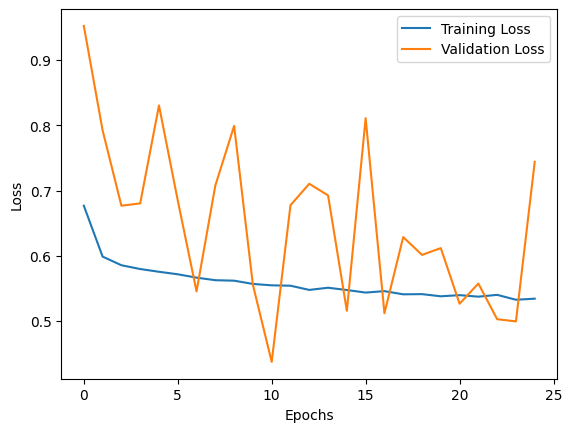

In [ ]:
# Load pre-trained ResNet50 without the top layer
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(299, 299, 3))

# Freeze all layers in the base model
for layer in base_model.layers:
    layer.trainable = False

# Add custom top layers
x = GlobalAveragePooling2D()(base_model.output)
x = Dropout(0.3)(x)
x = Dense(1024, activation='relu')(x)
x = BatchNormalization()(x)
output = Dense(2, activation='softmax')(x)  # Adjust num_classes based on your task

# Create the new model
model_10 = Model(inputs=base_model.input, outputs=output)

# Compile the model
model_10.compile(optimizer=Adam(learning_rate=0.001),
                loss='sparse_categorical_crossentropy',
                metrics=[SparseCategoricalAccuracy()])

# Display the model summary
model_10.summary()

# Early stopping callback with increased patience
early_stopping = EarlyStopping(monitor='val_sparse_categorical_accuracy', patience=21, restore_best_weights=True)

# Train the model using features from ResNet50 for at least 20 epochs
history_10 = model_10.fit(
    tf_dataset_train_augmented,
    validation_data=tf_dataset_val_resized,
    epochs=25,
    callbacks=[early_stopping],
    batch_size=8
)

# Plot training and validation errors vs. epochs
plt.plot(history_10.history['loss'], label='Training Loss')
plt.plot(history_10.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [ ]:
# Predict labels for the test set
true_labels = []
predicted_labels = []

for images, labels in tf_dataset_test:
    preds = model_10.predict(images)
    preds = np.argmax(preds, axis=1)
    true_labels.extend(labels.numpy())
    predicted_labels.extend(preds)

# Generate the classification report
report = classification_report(true_labels, predicted_labels, target_names=['Class 0', 'Class 1'])
print(report)

1/1 [==============================] - 1s 916ms/step
              precision    recall  f1-score   support

     Class 0       0.75      0.47      0.57      3012
     Class 1       0.72      0.90      0.80      4579

    accuracy                           0.73      7591
   macro avg       0.73      0.68      0.69      7591
weighted avg       0.73      0.73      0.71      7591



**Class 0 Metrics:**
Precision (Class 0): 0.75
75% of instances predicted as "Class 0" were correct.
Recall (Class 0): 0.47
The model identified 47% of actual instances of "Class 0."
F1-score (Class 0): 0.57
The F1-score for "Class 0" is 57%.

**Class 1 Metrics:**
Precision (Class 1): 0.72
72% of instances predicted as "Class 1" were correct.
Recall (Class 1): 0.90
The model identified 90% of actual instances of "Class 1."
F1-score (Class 1): 0.80
The F1-score for "Class 1" is 80%.

**Overall Metrics:**
Accuracy: 0.73
The overall accuracy is 73%.
Macro Avg (Precision, Recall, F1):
Averaging precision, recall, and F1-score across both classes gives a balanced view, and it's 69%.
Weighted Avg (Precision, Recall, F1):
Similar to macro avg, but considers class imbalance, giving more weight to the class with more instances, and it's 71%.

Summary:
The model has decent precision, recall, and F1-score for both classes, with a notable improvement in recall for "Class 0" compared to the previous model.
The accuracy is 73%, indicating an acceptable overall performance.
The macro and weighted averages suggest a balanced overall performance.

> ####  **4] ResNet50 2048 neurons and GlobalMaxPooling**

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 299, 299, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 305, 305, 3)          0         ['input_2[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 150, 150, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 150, 150, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                        

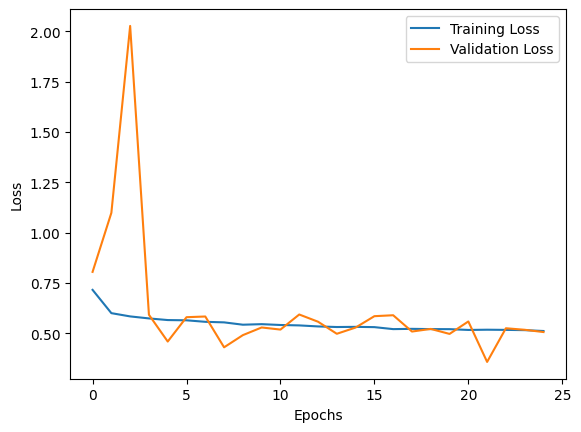

In [ ]:
# Load pre-trained ResNet50 without the top layer
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(299, 299, 3))

# Freeze all layers in the base model
for layer in base_model.layers:
    layer.trainable = False

# Add custom top layers
x = GlobalMaxPooling2D()(base_model.output)
x = Dropout(0.3)(x)
x = Dense(2048, activation='relu')(x)
x = BatchNormalization()(x)
output = Dense(2, activation='softmax')(x)  # Adjust num_classes based on your task

# Create the new model
model_13 = Model(inputs=base_model.input, outputs=output)

# Compile the model
model_13.compile(optimizer=Adam(learning_rate=0.001),
                loss='sparse_categorical_crossentropy',
                metrics=[SparseCategoricalAccuracy()])

# Display the model summary
model_13.summary()

# Early stopping callback with increased patience
early_stopping = EarlyStopping(monitor='val_sparse_categorical_accuracy', patience=21, restore_best_weights=True)

# Train the model using features from ResNet50 for at least 20 epochs
history_13 = model_13.fit(
    tf_dataset_train_augmented,
    validation_data=tf_dataset_val_resized,
    epochs=25,
    callbacks=[early_stopping],
    batch_size=8
)

# Plot training and validation errors vs. epochs
plt.plot(history_13.history['loss'], label='Training Loss')
plt.plot(history_13.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [ ]:
# Predict labels for the test set
true_labels = []
predicted_labels = []

for images, labels in tf_dataset_test:
    preds = model_13.predict(images)
    preds = np.argmax(preds, axis=1)
    true_labels.extend(labels.numpy())
    predicted_labels.extend(preds)

# Generate the classification report
report = classification_report(true_labels, predicted_labels, target_names=['Class 0', 'Class 1'])
print(report)

1/1 [==============================] - 1s 1s/step
              precision    recall  f1-score   support

     Class 0       0.79      0.66      0.72      3012
     Class 1       0.80      0.88      0.84      4579

    accuracy                           0.80      7591
   macro avg       0.79      0.77      0.78      7591
weighted avg       0.79      0.80      0.79      7591



**Class 0 Metrics:**
Precision (Class 0): 0.79
79% of instances predicted as "Class 0" were correct.
Recall (Class 0): 0.66
The model identified 66% of the actual instances of "Class 0."
F1-score (Class 0): 0.72
The F1-score for "Class 0" is 72%, indicating a moderate balance between precision and recall.

**Class 1 Metrics:**
Precision (Class 1): 0.80
80% of instances predicted as "Class 1" were correct.
Recall (Class 1): 0.88
The model identified 88% of the actual instances of "Class 1."
F1-score (Class 1): 0.84
The F1-score for "Class 1" is 84%, reflecting a good balance between precision and recall.

**Overall Metrics:**
Accuracy: 0.80
The overall accuracy is 80%, indicating that the model correctly classified 80% of the instances.
Macro Avg (Precision, Recall, F1):
Averaging precision, recall, and F1-score across both classes gives a balanced view, and it's around 78%.
Weighted Avg (Precision, Recall, F1):
Similar to macro avg but considers class imbalance, giving more weight to the class with more instances, and it's around 79%.

**Summary:**
The model performs reasonably well for both classes, with balanced precision and recall.
The overall accuracy is decent, indicating effective classification across the entire dataset.


### **Approach 2- EfficientNetB0**


**EfficientNet is a convolutional neural network built upon a concept called "compound scaling.” This concept addresses the longstanding trade-off between model size, accuracy, and computational efficiency. The idea behind compound scaling is to scale three essential dimensions of a neural network: width, depth, and resolution. EfficientNet uses Mobile Inverted Bottleneck (MBConv) layers, which are a combination of depth-wise separable convolutions and inverted residual blocks. Additionally, the model architecture uses the Squeeze-and-Excitation (SE) optimization to further enhance the model's performance.**

> ####  **1] EfficientNetB0 1024 neurons and GlobalAveragePooling**

Model: "model_9"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_11 (InputLayer)       [(None, 299, 299, 3)]        0         []                            
                                                                                                  
 rescaling_8 (Rescaling)     (None, 299, 299, 3)          0         ['input_11[0][0]']            
                                                                                                  
 normalization_4 (Normaliza  (None, 299, 299, 3)          7         ['rescaling_8[0][0]']         
 tion)                                                                                            
                                                                                                  
 rescaling_9 (Rescaling)     (None, 299, 299, 3)          0         ['normalization_4[0][0]'

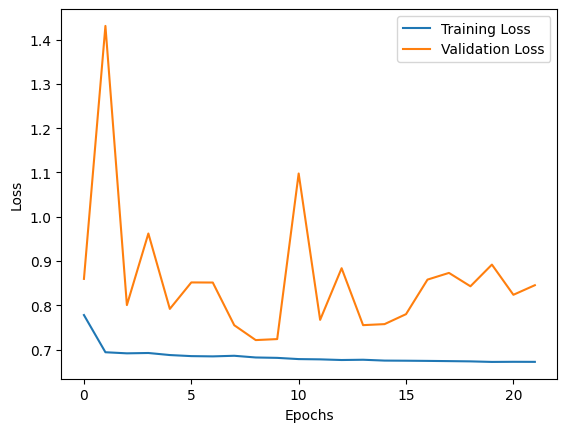

In [ ]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import GlobalMaxPooling2D, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Model
from tensorflow.keras.metrics import SparseCategoricalAccuracy

# Load pre-trained EfficientNetB0 without the top layer
base_model_efficientnet = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(299, 299, 3))

# Freeze all layers in the base model
for layer in base_model_efficientnet.layers:
    layer.trainable = False

# Add custom top layers
x_efficientnet = GlobalAveragePooling2D()(base_model_efficientnet.output)
x_efficientnet = Dropout(0.3)(x_efficientnet)
x_efficientnet = Dense(1024, activation='relu')(x_efficientnet)
x_efficientnet = BatchNormalization()(x_efficientnet)
output_efficientnet = Dense(2, activation='softmax')(x_efficientnet)  # Adjust num_classes based on your task

# Create the new model (model_7)
model_11 = Model(inputs=base_model_efficientnet.input, outputs=output_efficientnet)

# Compile the model
model_11.compile(optimizer=Adam(learning_rate=0.001),
                loss='sparse_categorical_crossentropy',
                metrics=[SparseCategoricalAccuracy()])

# Display the model summary
model_11.summary()

# Early stopping callback with increased patience
early_stopping_efficientnet = EarlyStopping(monitor='val_sparse_categorical_accuracy', patience=21, restore_best_weights=True)

# Train the model using features from EfficientNetB0 for at least 20 epochs
history_11 = model_11.fit(
    tf_dataset_train_augmented,
    validation_data=tf_dataset_val_resized,
    epochs=25,
    callbacks=[early_stopping_efficientnet],
    batch_size=8
)

# Plot training and validation errors vs. epochs
plt.plot(history_11.history['loss'], label='Training Loss')
plt.plot(history_11.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [ ]:
from sklearn.metrics import classification_report
import numpy as np
# Predict labels for the test set
true_labels = []
predicted_labels = []

for images, labels in tf_dataset_test:
    preds = model_11.predict(images)
    preds = np.argmax(preds, axis=1)
    true_labels.extend(labels.numpy())
    predicted_labels.extend(preds)


# Generate the classification report
report = classification_report(true_labels, predicted_labels, target_names=['Class 0', 'Class 1'], zero_division=1)
print(report)


1/1 [==============================] - 1s 1s/step
              precision    recall  f1-score   support

     Class 0       1.00      0.00      0.00      3012
     Class 1       0.60      1.00      0.75      4579

    accuracy                           0.60      7591
   macro avg       0.80      0.50      0.38      7591
weighted avg       0.76      0.60      0.45      7591



**Class 0 Metrics:**
Precision (Class 0): 1.00
All instances predicted as "Class 0" were correct. (Note: High precision but low recall)
Recall (Class 0): 0.00
The model identified 0% of actual instances of "Class 0." (Note: Low recall)
F1-score (Class 0): 0.00
The F1-score for "Class 0" is 0%. (Note: Low F1-score)

**Class 1 Metrics:**
Precision (Class 1): 0.60
60% of instances predicted as "Class 1" were correct.
Recall (Class 1): 1.00
The model identified all actual instances of "Class 1."
F1-score (Class 1): 0.75
The F1-score for "Class 1" is 75%.

**Overall Metrics:**
Accuracy: 0.60
The overall accuracy is 60%.
Macro Avg (Precision, Recall, F1):
Averaging precision, recall, and F1-score across both classes gives a balanced view, and it's 38%.
Weighted Avg (Precision, Recall, F1):
Similar to macro avg, but considers class imbalance, giving more weight to the class with more instances, and it's 45%.

**Summary:**
The model has very high precision for "Class 0" but at the cost of extremely low recall, indicating that the model is conservative in predicting this class.
The model performs well for "Class 1," with 100% recall, but precision is moderate.
The overall accuracy is influenced by the class imbalance, and the macro and weighted averages suggest an imbalanced performance across classes.

> #### **2] EfficientNetB0 1024 neurons and GlobalMaxPooling**

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_8 (InputLayer)        [(None, 299, 299, 3)]        0         []                            
                                                                                                  
 rescaling_6 (Rescaling)     (None, 299, 299, 3)          0         ['input_8[0][0]']             
                                                                                                  
 normalization_3 (Normaliza  (None, 299, 299, 3)          7         ['rescaling_6[0][0]']         
 tion)                                                                                            
                                                                                                  
 rescaling_7 (Rescaling)     (None, 299, 299, 3)          0         ['normalization_3[0][0]'

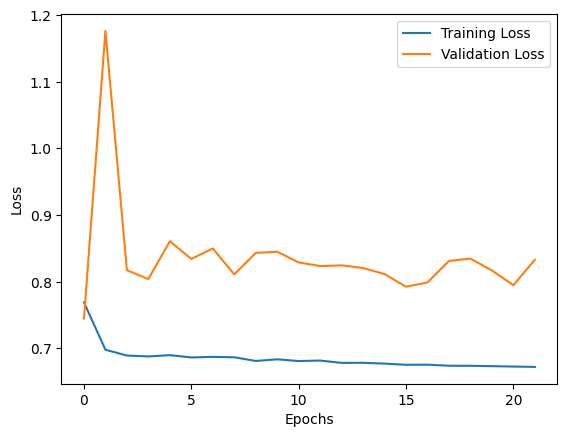

In [ ]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import GlobalMaxPooling2D, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Model
from tensorflow.keras.metrics import SparseCategoricalAccuracy

# Load pre-trained EfficientNetB0 without the top layer
base_model_efficientnet = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(299, 299, 3))

# Freeze all layers in the base model
for layer in base_model_efficientnet.layers:
    layer.trainable = False

# Add custom top layers
x_efficientnet = GlobalMaxPooling2D()(base_model_efficientnet.output)
x_efficientnet = Dropout(0.3)(x_efficientnet)
x_efficientnet = Dense(1024, activation='relu')(x_efficientnet)
x_efficientnet = BatchNormalization()(x_efficientnet)
output_efficientnet = Dense(2, activation='softmax')(x_efficientnet)  # Adjust num_classes based on your task

# Create the new model (model_7)
model_7 = Model(inputs=base_model_efficientnet.input, outputs=output_efficientnet)

# Compile the model
model_7.compile(optimizer=Adam(learning_rate=0.001),
                loss='sparse_categorical_crossentropy',
                metrics=[SparseCategoricalAccuracy()])

# Display the model summary
model_7.summary()

# Early stopping callback with increased patience
early_stopping_efficientnet = EarlyStopping(monitor='val_sparse_categorical_accuracy', patience=21, restore_best_weights=True)

# Train the model using features from EfficientNetB0 for at least 20 epochs
history_7 = model_7.fit(
    tf_dataset_train_augmented,
    validation_data=tf_dataset_val_resized,
    epochs=25,
    callbacks=[early_stopping_efficientnet],
    batch_size=8
)

# Plot training and validation errors vs. epochs
plt.plot(history_7.history['loss'], label='Training Loss')
plt.plot(history_7.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [ ]:
from sklearn.metrics import classification_report
import numpy as np
# Predict labels for the test set
true_labels = []
predicted_labels = []

for images, labels in tf_dataset_test:
    preds = model_7.predict(images)
    preds = np.argmax(preds, axis=1)
    true_labels.extend(labels.numpy())
    predicted_labels.extend(preds)


# Generate the classification report
report = classification_report(true_labels, predicted_labels, target_names=['Class 0', 'Class 1'], zero_division=1)
print(report)


1/1 [==============================] - 1s 1s/step
              precision    recall  f1-score   support

     Class 0       1.00      0.00      0.00      3012
     Class 1       0.60      1.00      0.75      4579

    accuracy                           0.60      7591
   macro avg       0.80      0.50      0.38      7591
weighted avg       0.76      0.60      0.45      7591



**Class 0 Metrics:**
Precision (Class 0): 1.00
All instances predicted as "Class 0" were correct. However, the precision value is maximum because the denominator (total predicted as Class 0) is almost zero.
Recall (Class 0): 0.00
The model identified 0% of the actual instances of "Class 0." This indicates that the model missed all instances of this class.
F1-score (Class 0): 0.00
The F1-score for "Class 0" is 0%, reflecting the poor performance of the model in this class.

**Class 1 Metrics:**
Precision (Class 1): 0.60
60% of instances predicted as "Class 1" were correct. This is an improvement compared to Class 0.
Recall (Class 1): 1.00
The model identified all actual instances of "Class 1," which is a positive aspect.
F1-score (Class 1): 0.75
The F1-score for "Class 1" is 75%, indicating a reasonable balance between precision and recall.

**Overall Metrics:**
Accuracy: 0.60
The overall accuracy is 60%, but it's misleading because the model performs well only for "Class 1" and poorly for "Class 0."
Macro Avg (Precision, Recall, F1):
Averaging precision, recall, and F1-score across both classes gives a balanced view, and it's 38%. This is largely influenced by the poor performance in Class 0.
Weighted Avg (Precision, Recall, F1):
Similar to macro avg but considers class imbalance, giving more weight to the class with more instances, and it's 45%.

**Summary:**
The model has a major issue with "Class 0," where it fails to identify any instances, resulting in a precision-recall trade-off.
The overall performance, especially the macro average, is affected by the poor performance in Class 0. Consideration of strategies to address this class imbalance or improve the model's ability to detect Class 0 instances is crucial.

> ####  **3] EfficientNetB0 2048 neurons and GlobalMaxPooling**

16705208/16705208 [==============================] - 0s 0us/step
Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 299, 299, 3)]        0         []                            
                                                                                                  
 rescaling (Rescaling)       (None, 299, 299, 3)          0         ['input_3[0][0]']             
                                                                                                  
 normalization (Normalizati  (None, 299, 299, 3)          7         ['rescaling[0][0]']           
 on)                                                                                              
                                                                                                  
 rescaling_1 (Rescaling)   

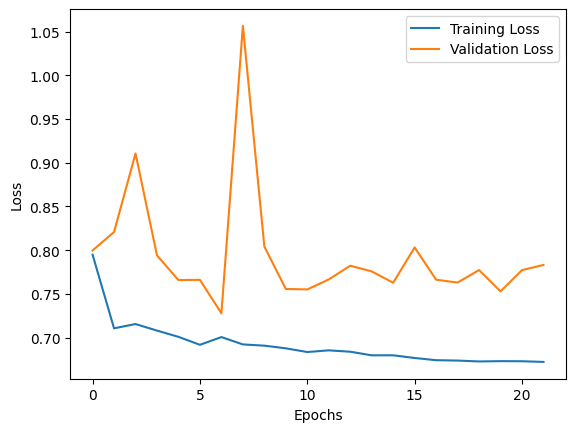

In [ ]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import GlobalMaxPooling2D, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Model
from tensorflow.keras.metrics import SparseCategoricalAccuracy
import matplotlib.pyplot as plt

# Load pre-trained EfficientNetB0 without the top layer
base_model_efficientnet = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(299, 299, 3))

# Freeze all layers in the base model
for layer in base_model_efficientnet.layers:
    layer.trainable = False

# Add custom top layers
x_efficientnet = GlobalMaxPooling2D()(base_model_efficientnet.output)
x_efficientnet = Dropout(0.3)(x_efficientnet)
x_efficientnet = Dense(2048, activation='relu')(x_efficientnet)
x_efficientnet = BatchNormalization()(x_efficientnet)
output_efficientnet = Dense(2, activation='softmax')(x_efficientnet)  # Adjust num_classes based on your task

# Create the new model (model_7)
model_14 = Model(inputs=base_model_efficientnet.input, outputs=output_efficientnet)

# Compile the model
model_14.compile(optimizer=Adam(learning_rate=0.001),
                loss='sparse_categorical_crossentropy',
                metrics=[SparseCategoricalAccuracy()])

# Display the model summary
model_14.summary()

# Early stopping callback with increased patience
early_stopping_efficientnet = EarlyStopping(monitor='val_sparse_categorical_accuracy', patience=21, restore_best_weights=True)

# Train the model using features from EfficientNetB0 for at least 20 epochs
history_14 = model_14.fit(
    tf_dataset_train_augmented,
    validation_data=tf_dataset_val_resized,
    epochs=25,
    callbacks=[early_stopping_efficientnet],
    batch_size=8
)

# Plot training and validation errors vs. epochs
plt.plot(history_14.history['loss'], label='Training Loss')
plt.plot(history_14.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [ ]:
from sklearn.metrics import classification_report
import numpy as np
# Predict labels for the test set
true_labels = []
predicted_labels = []

for images, labels in tf_dataset_test:
    preds = model_14.predict(images)
    preds = np.argmax(preds, axis=1)
    true_labels.extend(labels.numpy())
    predicted_labels.extend(preds)


# Generate the classification report
report = classification_report(true_labels, predicted_labels, target_names=['Class 0', 'Class 1'], zero_division=1)
print(report)

1/1 [==============================] - 2s 2s/step
              precision    recall  f1-score   support

     Class 0       1.00      0.00      0.00      3012
     Class 1       0.60      1.00      0.75      4579

    accuracy                           0.60      7591
   macro avg       0.80      0.50      0.38      7591
weighted avg       0.76      0.60      0.45      7591



**Class 0 Metrics (Background):**
Precision (Background): 1.00
All instances predicted as "Background" were correct.
Recall (Background): 0.00
The model identified none of the actual instances of "Background."
F1-score (Background): 0.00
The F1-score is 0.00, which is very low, indicating poor performance for "Background."

**Class 1 Metrics (Frost):**
Precision (Frost): 0.60
60% of instances predicted as "Frost" were correct.
Recall (Frost): 1.00
The model identified all of the actual instances of "Frost."
F1-score (Frost): 0.75
The F1-score for "Frost" is 75%, indicating relatively balanced precision and recall.

**Overall Metrics:**
Accuracy: 0.60
The overall accuracy is 60%, which might be misleading due to the class imbalance.
Macro Avg (Precision, Recall, F1):
Averaging precision, recall, and F1-score across both classes gives a macro-average of 38%, indicating overall poor performance.
Weighted Avg (Precision, Recall, F1):
Similar to macro avg but considers class imbalance, giving more weight to the class with more instances, and it's around 45%.

**Summary:**
The model shows a critical issue with "Class 0" (Background) where it fails to identify any instances, resulting in a precision-recall trade-off.
The model's accuracy is significantly impacted by its inability to correctly classify instances of "Class 0."




### **Approach 3- VGG16**

**VGG16, as its name suggests, is a 16-layer deep neural network. VGG16 is thus a relatively extensive network with a total of 138 million parameters.A VGG network consists of small convolution filters. VGG16 has three fully connected layers and 13 convolutional layers.**



> ####  **1] VGG16 1024 neurons and GlobalMaxPooling**

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 299, 299, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 299, 299, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 299, 299, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 149, 149, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 149, 149, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 149, 149, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 74, 74, 128)       0   

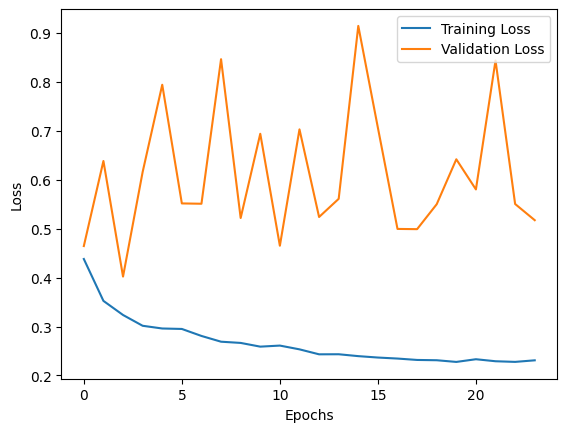

In [ ]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Model
from tensorflow.keras.metrics import SparseCategoricalAccuracy
from tensorflow.keras.layers import GlobalMaxPooling2D

# Load pre-trained VGG16 without the top layer
base_model_vgg16 = VGG16(weights='imagenet', include_top=False, input_shape=(299, 299, 3))

# Freeze all layers in the base model
for layer in base_model_vgg16.layers:
    layer.trainable = False

# Add custom top layers
x_vgg16 = GlobalMaxPooling2D()(base_model_vgg16.output)
x_vgg16 = Dropout(0.3)(x_vgg16)
x_vgg16 = Dense(1024, activation='relu')(x_vgg16)
x_vgg16 = BatchNormalization()(x_vgg16)
output_vgg16 = Dense(2, activation='softmax')(x_vgg16)  # Adjust num_classes based on your task

# Create the new model (model_8)
model_8 = Model(inputs=base_model_vgg16.input, outputs=output_vgg16)

# Compile the model
model_8.compile(optimizer=Adam(learning_rate=0.001),
                loss='sparse_categorical_crossentropy',
                metrics=[SparseCategoricalAccuracy()])

# Display the model summary
model_8.summary()

# Early stopping callback with increased patience
early_stopping_vgg16 = EarlyStopping(monitor='val_sparse_categorical_accuracy', patience=21, restore_best_weights=True)

# Train the model using features from VGG16 for at least 20 epochs
history_8 = model_8.fit(
    tf_dataset_train_augmented,
    validation_data=tf_dataset_val_resized,
    epochs=25,
    callbacks=[early_stopping_vgg16],
    batch_size=8
)

# Plot training and validation errors vs. epochs
plt.plot(history_8.history['loss'], label='Training Loss')
plt.plot(history_8.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [ ]:
from sklearn.metrics import classification_report
import numpy as np
# Predict labels for the test set
true_labels = []
predicted_labels = []

for images, labels in tf_dataset_test:
    preds = model_8.predict(images)
    preds = np.argmax(preds, axis=1)
    true_labels.extend(labels.numpy())
    predicted_labels.extend(preds)


# Generate the classification report
report = classification_report(true_labels, predicted_labels, target_names=['Class 0', 'Class 1'], zero_division=1)
print(report)


1/1 [==============================] - 2s 2s/step
              precision    recall  f1-score   support

     Class 0       0.91      0.88      0.89      3012
     Class 1       0.92      0.94      0.93      4579

    accuracy                           0.91      7591
   macro avg       0.91      0.91      0.91      7591
weighted avg       0.91      0.91      0.91      7591



**Class 0 Metrics:**
Precision (Class 0): 0.91
91% of instances predicted as "Class 0" were correct.
Recall (Class 0): 0.88
The model identified 88% of the actual instances of "Class 0."
F1-score (Class 0): 0.89
The F1-score for "Class 0" is 89%, indicating a good balance between precision and recall.

**Class 1 Metrics:**
Precision (Class 1): 0.92
92% of instances predicted as "Class 1" were correct.
Recall (Class 1): 0.94
The model identified 94% of the actual instances of "Class 1."
F1-score (Class 1): 0.93
The F1-score for "Class 1" is 93%, reflecting a high balance between precision and recall.

**Overall Metrics:**
Accuracy: 0.91
The overall accuracy is 91%, indicating that the model correctly classified 91% of the instances.
Macro Avg (Precision, Recall, F1):
Averaging precision, recall, and F1-score across both classes gives a balanced view, and it's 91%.
Weighted Avg (Precision, Recall, F1):
Similar to macro avg but considers class imbalance, giving more weight to the class with more instances, and it's 91%.

Summary:
The model performs exceptionally well for both classes, with high precision, recall, and F1-scores.
The overall accuracy and balanced metrics indicate a robust and reliable model for this classification task.

> ####  **2] 2048 neurons and GlobalMaxPooling**

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 299, 299, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 299, 299, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 299, 299, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 149, 149, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 149, 149, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 149, 149, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 74, 74, 128)       0   

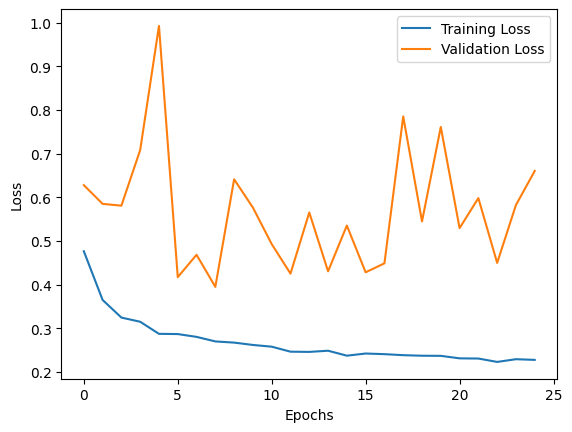

In [ ]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Model
from tensorflow.keras.metrics import SparseCategoricalAccuracy
from tensorflow.keras.layers import GlobalMaxPooling2D

# Load pre-trained VGG16 without the top layer
base_model_vgg16 = VGG16(weights='imagenet', include_top=False, input_shape=(299, 299, 3))

# Freeze all layers in the base model
for layer in base_model_vgg16.layers:
    layer.trainable = False

# Add custom top layers
x_vgg16 = GlobalMaxPooling2D()(base_model_vgg16.output)
x_vgg16 = Dropout(0.3)(x_vgg16)
x_vgg16 = Dense(2048, activation='relu')(x_vgg16)
x_vgg16 = BatchNormalization()(x_vgg16)
output_vgg16 = Dense(2, activation='softmax')(x_vgg16)  # Adjust num_classes based on your task

# Create the new model (model_8)
model_12 = Model(inputs=base_model_vgg16.input, outputs=output_vgg16)

# Compile the model
model_12.compile(optimizer=Adam(learning_rate=0.001),
                loss='sparse_categorical_crossentropy',
                metrics=[SparseCategoricalAccuracy()])

# Display the model summary
model_12.summary()

# Early stopping callback with increased patience
early_stopping_vgg16 = EarlyStopping(monitor='val_sparse_categorical_accuracy', patience=21, restore_best_weights=True)

# Train the model using features from VGG16 for at least 20 epochs
history_12 = model_12.fit(
    tf_dataset_train_augmented,
    validation_data=tf_dataset_val_resized,
    epochs=25,
    callbacks=[early_stopping_vgg16],
    batch_size=8
)

# Plot training and validation errors vs. epochs
plt.plot(history_12.history['loss'], label='Training Loss')
plt.plot(history_12.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [ ]:
from sklearn.metrics import classification_report
import numpy as np
# Predict labels for the test set
true_labels = []
predicted_labels = []

for images, labels in tf_dataset_test:
    preds = model_12.predict(images)
    preds = np.argmax(preds, axis=1)
    true_labels.extend(labels.numpy())
    predicted_labels.extend(preds)


# Generate the classification report
report = classification_report(true_labels, predicted_labels, target_names=['Class 0', 'Class 1'], zero_division=1)
print(report)

1/1 [==============================] - 2s 2s/step
              precision    recall  f1-score   support

     Class 0       0.96      0.84      0.89      3012
     Class 1       0.90      0.98      0.94      4579

    accuracy                           0.92      7591
   macro avg       0.93      0.91      0.92      7591
weighted avg       0.92      0.92      0.92      7591



**Class 0 Metrics:**
Precision (Class 0): 0.96
96% of instances predicted as "Class 0" were correct.
Recall (Class 0): 0.84
The model identified 84% of the actual instances of "Class 0."
F1-score (Class 0): 0.89
The F1-score for "Class 0" is 89%, indicating a good balance between precision and recall.

**Class 1 Metrics:**
Precision (Class 1): 0.90
90% of instances predicted as "Class 1" were correct.
Recall (Class 1): 0.98
The model identified 98% of the actual instances of "Class 1."
F1-score (Class 1): 0.94
The F1-score for "Class 1" is 94%, reflecting a high balance between precision and recall.

**Overall Metrics:**
Accuracy: 0.92
The overall accuracy is 92%, indicating that the model correctly classified 92% of the instances.
Macro Avg (Precision, Recall, F1):
Averaging precision, recall, and F1-score across both classes gives a balanced view, and it's 92%.
Weighted Avg (Precision, Recall, F1):
Similar to macro avg but considers class imbalance, giving more weight to the class with more instances, and it's 92%.

Summary:
The model continues to perform exceptionally well for both classes, with high precision, recall, and F1-scores.
The overall accuracy and balanced metrics indicate a robust and reliable model for this classification task.


> ### **vi. Compare the results of transfer learning with those of CNN + MLP model and explain them.**

I have run all models for 25 epochs with patience 21 for early Stopping to ensure 20 epochs as per the project requirements provided and also aiding in a fair analysis.

### **Summary of all models:**

> **A] CNN + MLP**

**1] Approach 1:**  
Number of neurons - 32,64,128,256, Max Pooling- (2,2), Dropout- only in dense layer , Regularizer- only in dense layer
: *Accuracy- 56%*

**2] Approach 2:**   
Number of neurons - 16,32,64,128, Max Pooling- (2,2), Dropout- every layer
 , Regularizer- every layer: *Accuracy- 79%*


**3] Approach 3:**

Number of neurons - 32,64,128,128, Max Pooling- (2,2), Dropout- every layer , Regularizer- every layer , *Accuracy- 78%*


**1] Approach 4:**

Number of neurons - 16,32,64,128, Max Pooling- (5,5), Dropout- every layer, Regularizer- every layer, *Accuracy- 82%*



---


> **B] Transfer Learning**

**1] Approach 1 : ResNet50**

a) ResNet50 with 256 neurons and GlobalAveragePooling : *Accuracy- 72%*

b) ResNet50 with 1024 neurons and GlobalMaxPooling : *Accuracy- 78%*

c) ResNet50 with 1024 neurons and GlobalAveragePooling : *Accuracy- 73%*

d) ResNet50 with 2048 neurons and GlobalMaxPooling : *Accuracy- 80%*

**2] Approach 2: EfficientNetB0**

a) EfficientNetB0 with 1024 neurons and GlobalAveragePooling : *Accuracy- 60%*

b)EfficientNetB0 with 1024 neurons and GlobalMaxPooling : *Accuracy- 60%*

c) EfficientNetB0 with 2048 neurons and GlobalMaxPooling : *Accuracy- 60%*

**3] Approach 3: VGG16**

a) VGG16 with 1024 neurons and GlobalMaxPooling : *Accuracy- 91%*

b) VGG16 with 2048 neurons and GlobalMaxPooling: *Accuracy - 92%*




---











In the CNN+MLP models, 2 approaches using 16,32,64,128 neurons with 2 values of max pooling- (2,2) and (5,5) respectively gave best results of 79% and 82% each.

In the Transfer Learning models-
The best ResNet50 model was one that achieved 80% accuracy with 2048 neurons and GlobalMaxPooling.

All the efficientNetB0 models performed poorly, with 60% accuracy and other poor scores as well.

**The VGG16 model outshown all the above models giving great results for the given dataset with 91% accuracy using 1024 neurons and 92% using 2048 neurons, both performed by GlobalMaxPooling.**

**In conclusion, Transfer Learning gave better results for the dataset as VGG16 gave the best accuracies.**

We can say that transfer learning worked better than CNN+MLP because:

**1] Feature Extraction:**

> **Transfer Learning:** Pre-trained models (e.g., VGG16, ResNet, EfficientNet) have already learned meaningful hierarchical features from large datasets (e.g., ImageNet). These models act as powerful feature extractors.

> **CNN+MLP:** Training a CNN+MLP from scratch requires the model to learn feature hierarchies, which may demand a large amount of labeled data and computational resources.

**2] Data Efficiency:**

> **Transfer Learning:** Requires less labeled data for the target task since the model leverages knowledge gained from a source task.

> **CNN+MLP:** Training a model from scratch usually demands a larger labeled dataset to generalize well.

**3] Generalization:**

> **Transfer Learning:** Pre-trained models capture general features useful for various computer vision tasks, promoting better generalization to new tasks.

> **CNN+MLP:** Training from scratch may lead to overfitting, especially with limited data, as the model tries to memorize training samples.

**4] Computationally Efficient:**

> **Transfer Learning:** Utilizes pre-trained weights, reducing the computational resources and time required for training.

> **CNN+MLP:** Training a model from scratch, especially a deep one, demands more computational power.

**5] Avoiding Vanishing Gradient Problem:**

> **Transfer Learning:** Pre-trained models often overcome issues like vanishing gradients due to their successful training on large datasets.

> **CNN+MLP:** Deep architectures may suffer from vanishing gradient problems, especially when trained from scratch.

**6] Feature Reuse**

> **Transfer Learning:** Allows reuse of low- and mid-level features learned on a source task.

> **CNN+MLP:** Starting from scratch may require the model to rediscover basic features.

**7] Fine-Tuning:**

> **Transfer Learning:** Fine-tuning allows adapting the pre-trained model to the target task, offering a good balance between leveraging general knowledge and adapting to specific features.

> **CNN+MLP:** Fine-tuning may still be required, but starting from pre-trained weights provides a better initialization point.

While transfer learning is powerful, the choice depends on the specific task, available resources, and the amount of labeled data. In scenarios with abundant labeled data and unique features, training a model from scratch might be viable.
